In [1]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Import dataset

In [2]:
# Import dataset
mandiri = pd.read_csv("C:/Users/ASUS/Desktop/Daming/VSC/stock_price_prediction_with_realtime_evaluation/data/processed/data_model.csv")
mandiri.head()

,tanggal,harga
0,2020-01-01,7.750
1,2020-01-02,7.750
2,2020-01-03,7.725
3,2020-01-06,7.600
4,2020-01-07,7.600


## Covert date from string to date format

In [3]:
mandiri["tanggal"]=pd.to_datetime(mandiri.tanggal)
mandiri.dtypes

tanggal    datetime64[ns]
harga             float64
dtype: object

In [4]:
mandiri.shape

(1083, 2)

## Get the duration of dataset

In [5]:
print("Starting date: ",mandiri.iloc[0][0])
print("Ending date: ", mandiri.iloc[-1][0])
print("Duration: ", mandiri.iloc[-1][0]-mandiri.iloc[0][0])

Starting date:  2020-01-01 00:00:00
Ending date:  2024-02-23 00:00:00
Duration:  1514 days 00:00:00


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2232\73743492.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Starting date: ",mandiri.iloc[0][0])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2232\73743492.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Ending date: ", mandiri.iloc[-1][0])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2232\73743492.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Duration: ", m

## Normalizing / scaling close value between 0 to 1

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
mandiri_norm=scaler.fit_transform(mandiri[["harga"]])
print(mandiri_norm.shape)

(1083, 1)


## Split data

In [7]:
training_size=int(len(mandiri_norm)*0.65)
test_size=len(mandiri_norm)-training_size

train_data,test_data=mandiri_norm[0:training_size,:],mandiri_norm[training_size:len(mandiri_norm),:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (703, 1)
test_data:  (380, 1)


## Create new dataset

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (687, 15)
y_train:  (687,)
X_test:  (364, 15)
y_test (364,)


## LSTM

In [10]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (687, 15, 1)
X_test:  (364, 15, 1)


## LSTM model structure

In [11]:
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1)

Epoch 1/200

138/138 [==============================] - 5s 15ms/step - loss: 0.0132 - val_loss: 0.0111
Epoch 2/200
138/138 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0114
Epoch 3/200
138/138 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 4/200
138/138 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0074
Epoch 5/200
138/138 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0088
Epoch 6/200
138/138 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 7/200
138/138 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 8/200
138/138 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 9/200
138/138 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 10/200
138/138 [==============================] - 1s 10ms/step - loss: 0.00

In [14]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

12/12 [==============================] - 0s 3ms/step


((687, 1), (364, 1))

In [15]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

## Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [16]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.1307801379780241
Train data MSE:  0.01710344448955102
Test data MAE:  0.09406311654281063
-------------------------------------------------------------------------------------
Test data RMSE:  0.37416794041051704
Test data MSE:  0.14000164763104822
Test data MAE:  0.16094138336705638


In [17]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9869173092440593
Test data R2 score: 0.9681384437654577


### Comparision between original stock close price vs predicted close price

In [18]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(mandiri_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(mandiri_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(train_predict)+(look_back*2)+1+len(test_predict), :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original harga price','Train predicted harga price','Test predicted harga price'])


plotdf = pd.DataFrame({'date': mandiri['tanggal'],
                       'original_harga': mandiri['harga'],
                      'train_predicted_harga': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_harga': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_harga'],plotdf['train_predicted_harga'],
                                          plotdf['test_predicted_harga']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original harga price vs predicted harga price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1083, 1)
Test predicted data:  (1083, 1)


## Lets forcast

In [40]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [39]:
mandiri_norm.shape

(1083, 1)

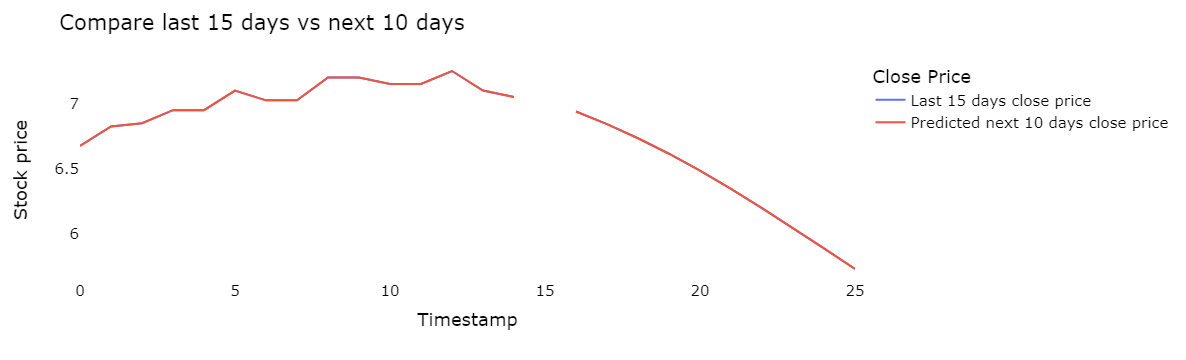

In [21]:
last_days=np.arange(1,time_step+1)
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(mandiri_norm[len(mandiri_norm)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## LSTM + GRU model structure

In [22]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 gru (GRU)                   (None, 15, 32)            6336      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 25377 (99.13 KB)
Trainable params: 25377 (99.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
132/132 [==============================] - 7s 20ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 2/200
132/132 [==============================] - 2s 13ms/step - loss: 0.0034 - val_loss: 0.0100
Epoch 3/200
132/132 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0098
Epoch 4/200
132/132 [==============================] - 2s 12ms/step - loss: 0.0026 - val_loss: 0.0158
Epoch 5/200
132/132 [==============================] - 2s 12ms/step - loss: 0.0022 - val_loss: 0.0078
Epoch 6/200
132/132 [==============================] - 2s 12ms/step - loss: 0.0019 - val_loss: 0.0060
Epoch 7/200
132/132 [==============================] - 2s 12ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 8/200
132/132 [==============================] - 2s 12ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 9/200
132/132 [==============================] - 2s 12ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 10/200
132/132 [==============================] - 2s 12ms/step - loss: 9.941

In [25]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

11/11 [==============================] - 0s 4ms/step


((656, 1), (347, 1))

In [26]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

## Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [27]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  0.1402304554311951
Train data MSE:  0.019664580630440402
Test data MAE:  0.10493431063686928
-------------------------------------------------------------------------------------
Test data RMSE:  0.5488158875002878
Test data MSE:  0.30119887837272846
Test data MAE:  0.18063224165171643


In [28]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9851377293419742
Test data R2 score: 0.9318584392164304


### Comparision between original stock close price vs predicted close price

Train predicted data:  (1035, 1)
Test predicted data:  (1035, 1)


C:\Users\ASUS\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



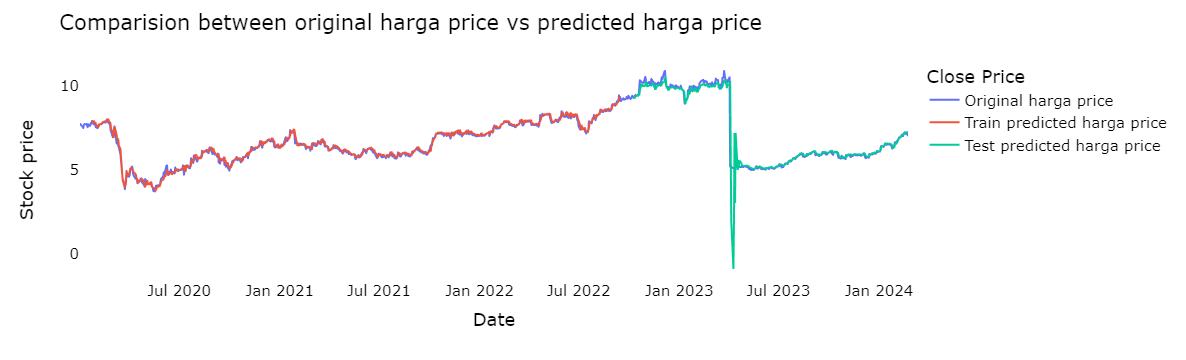

In [29]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(mandiri_norm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(mandiri_norm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(train_predict)+(look_back*2)+1+len(test_predict), :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original harga price','Train predicted harga price','Test predicted harga price'])


plotdf = pd.DataFrame({'date': mandiri['tanggal'],
                       'original_harga': mandiri['harga'],
                      'train_predicted_harga': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_harga': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_harga'],plotdf['train_predicted_harga'],
                                          plotdf['test_predicted_harga']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original harga price vs predicted harga price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

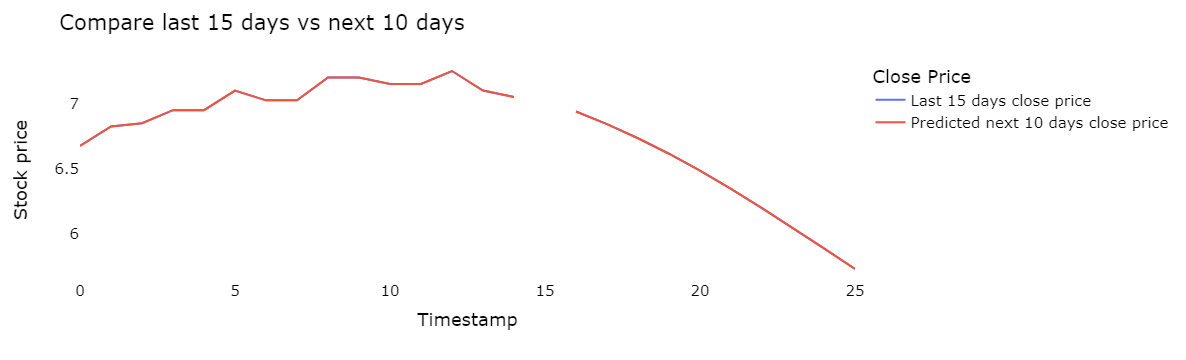

In [30]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(mandiri_norm[len(mandiri_norm)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

#### Meskipun GRU+LSTM memiliki accuracy lebih tinggi di train namun dengan adanya perbedaan antara test dan train lebih dari 10% merupakan indikasi overfit maka saya lebih pilih menggunakan LSTM saja dalam kasus ini